In [109]:
import pandas as pd
import numpy as np
import pandas_ta as ta

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder


import warnings
warnings.filterwarnings('ignore')


X_scaler = StandardScaler()
y_scaler = OneHotEncoder()



In [110]:

df = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/Data.csv', index_col=0, parse_dates=True)

# convert risk free rate to daily
df['Risk Free Rate'] = (1 + df['Risk Free Rate']) ** (1/365) - 1


df.head()

,Open,High,Low,Close,Volume,Risk Free Rate
2015-07-20,277.98,280.00,277.37,280.00,782.883420,0.000064
2015-07-21,279.96,281.27,276.85,277.32,4943.559434,0.000063
2015-07-22,277.33,278.54,275.01,277.89,4687.909383,0.000063
2015-07-23,277.96,279.75,276.28,277.39,5306.919575,0.000062
2015-07-24,277.23,291.52,276.43,289.12,7362.469083,0.000062


# Functions

In [111]:
# create optimal signals
def optStrat(prices, risk_free_rate, transaction_cost=0.001):

        T = len(prices)-1  # Number of trading days
        
        # Calculate Bitcoin daily returns
        btc_returns = [(prices[t+1] - prices[t])/prices[t] for t in range(T)]
        
        # Initialize memoization table and decisions
        memo = np.zeros((T+1, 2))
        decisions = np.zeros((T, 2), dtype=int)
        
        # Fill table bottom-up
        for t in range(T-1, -1, -1):
            for prev_action in [0, 1]:
                # Option 1: Bitcoin
                btc_return = btc_returns[t]
                if prev_action == 0:  # Switch to Bitcoin
                    value_bitcoin = btc_return - transaction_cost + memo[t+1, 1]
                elif prev_action == 1:  # Stay in Bitcoin
                    value_bitcoin = btc_return + memo[t+1, 1]
                
                # Option 2: Risk-free
                if prev_action == 1:  # Switch to risk-free
                    value_risk_free = risk_free_rate[t] - transaction_cost + memo[t+1, 0]
                elif prev_action == 0:  # Stay in risk-free
                    value_risk_free = risk_free_rate[t] + memo[t+1, 0]
                
                # Select better option
                if value_bitcoin > value_risk_free:
                    memo[t, prev_action] = value_bitcoin
                    decisions[t, prev_action] = 1
                else:
                    memo[t, prev_action] = value_risk_free
                    decisions[t, prev_action] = 0
        
        # Reconstruct optimal policy
        optimal_policy = []
        current_action = 0  # Assume we start with no position
        
        for t in range(T):
            current_action = decisions[t, current_action]
            optimal_policy.append(current_action)
        optimal_policy.append(np.nan)
        
        

        
        return optimal_policy



def signal_to_action(signals):
    # Convert to numpy array if not already
    signals = np.array(signals)
        
        # Get the differences between consecutive elements
    changes = np.diff(signals, prepend=0)
        
        # Initialize output array
    trading_signals = np.zeros_like(signals)
        
        # 1 when changing from 0 to 1 (buy signal)
    trading_signals[changes == 1] = 1
        
        # -1 when changing from 1 to 0 (sell signal)
    trading_signals[changes == -1] = -1
        
    return trading_signals


In [112]:
def returns(df):
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()
    df['Excess_Return'] = df['Returns'] - df['Risk Free Rate']
    return df

# need for ['Close', 'Returns', 'Signal', 'Excess_Return']
# for signal take window = [10, 20, 30, 40, 50]
def MA(df, column, window=[3, 5, 10, 30]):
    df = df.copy()
    # .rolling definietly looks backwards only.
    for w in window:
        df[f'MA_{column}_{w}'] = df[column].rolling(w).mean()
    return df


# need for ['Close', 'Returns', 'Signal', 'Excess_Return']
# for signal take window = [10, 20, 30, 40, 50]
def EMA(df, column, window=[3, 5, 10, 30]):
    df = df.copy()
    for w in window:
        df[f'EMA_{column}_{w}'] = df[column].ewm(span=w, adjust=False).mean()
    return df


# on close ()
def momentum(df, window=[3, 5, 10, 30]):
    df = df.copy()
    for w in window:
        df[f'Price_Momentum_{w}'] = df['Close'].pct_change(w)
    return df

def bollinger_bands(df, window=[5, 10, 20]):
    df = df.copy()
    for w in window:
        # add cols ['BBL_2.0', 'BBU_2.0', 'BBB_2.0', 'BBP_2.0']
        df.ta.bbands(length=w, append=True) 
        # remove the middle band as it is just the SMA which we already have
        df.drop(columns=[f'BBM_{w}_2.0'], inplace=True)

    return df

def average_true_range(df, window=[5, 10, 20]):
    df = df.copy()
    for w in window:
        df.ta.atr(length=w, append=True)
    return df

def relative_strength_index(df, window=[5, 10, 20]):
    df = df.copy()
    for w in window:
        df.ta.rsi(length=w, append=True)
    return df

def MACD(df):
    df = df.copy()
    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    return df

def stochastic_oscillator(df):
    df = df.copy()
    df.ta.stoch(append=True)
    return df

def ADX(df):
    df = df.copy()
    df.ta.adx(length=14, append=True)
    return df


# lagged signals
def lagged_signals(df, lags=[1, 2, 3, 4, 5]):
    df = df.copy()
    for lag in lags:
        df[f'Signal_Lag_{lag}'] = df['Signal'].shift(lag)
    return df



def add_all_features(df):
    df = df.copy()
    df = returns(df)

    for column in ['Close', 'Returns', 'Signal', 'Excess_Return']:
        df = MA(df, 'Close')
        df = EMA(df, 'Close')

    df = momentum(df)
    df = bollinger_bands(df)
    df = average_true_range(df)
    df = relative_strength_index(df)
    df = MACD(df)
    df = stochastic_oscillator(df)
    df = ADX(df)
    df = lagged_signals(df)

    # drop na
    df = df.dropna()
    
    return df


In [113]:

"""
Dimension Reduction
"""
def scale_data(X_train, y_train, X_test, y_test):

    global X_scaler
    global y_scaler

    X_cols = X_train.columns
    train_index = X_train.index
    test_index = X_test.index

    # transform the data
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_train = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
    y_test = y_scaler.transform(y_test.to_numpy().reshape(-1, 1)).toarray()



    X_train = pd.DataFrame(X_train, columns=X_cols, index=train_index)
    X_test = pd.DataFrame(X_test, columns=X_cols, index=test_index)
    y_train = pd.DataFrame(y_train, columns=['Signal_Sell', 'Signal_Hold', 'Signal_Buy'], index=train_index)
    y_test = pd.DataFrame(y_test, columns=['Signal_Sell', 'Signal_Hold', 'Signal_Buy'], index=test_index)

    return X_train, y_train, X_test, y_test



def select_top(X_train, y_train, X_test, y_test, k=25, plot=True):
    # scale data
    X_train, y_train, X_test, y_test = scale_data(X_train, y_train, X_test, y_test)

    # Select the top k features
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train, y_scaler.inverse_transform(y_train))

    # get the scores and sort
    feature_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False)
    

    # get the new df
    mask = X_train.columns[selector.get_support()]


    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Score', y='Feature', data=feature_scores.head(k))
        plt.title('Feature Scores')
        plt.xlabel('Score')
        plt.ylabel('Feature')
        plt.show()
        
    return X_train[mask], y_train, X_test[mask], y_test

    

def do_PCA(X_train, y_train, X_test, y_test, variance=0.95):
    # scale data
    X_train, y_train, X_test, y_test = scale_data(X_train, y_train, X_test, y_test)

    
    # fit the PCA
    pca = PCA(n_components=variance)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # get the new dfs
    X_train = pd.DataFrame(X_train, columns=[f'PC_{i}' for i in range(pca.n_components_)])
    X_test = pd.DataFrame(X_test, columns=[f'PC_{i}' for i in range(pca.n_components_)])

    # print the explained variance
    print(pca.explained_variance_ratio_)

    return X_train, y_train, X_test, y_test
    
    


# split into train and test

def split_data(df, date_split = '2021-01-01', start_date = df.index[0], end_date = df.index[-1]):
    # split the data into train and test
    df_train = df[start_date:date_split]
    df_test = df[date_split:end_date]

    # split into X and y
    X_train = df_train.drop(columns=['Signal'])
    y_train = df_train['Signal']

    X_test = df_test.drop(columns=['Signal'])
    y_test = df_test['Signal']

    return X_train, y_train, X_test, y_test


In [114]:
# Model helpers
from sklearn.metrics import confusion_matrix, classification_report


def vector_to_signal(vectors):
    return np.argmax(vectors, axis=1) - 1


def report(y_true, y_pred, y_proba):
    true = vector_to_signal(y_true)

    if y_pred.ndim > 1:
        pred = vector_to_signal(y_pred)
    else:
        pred = y_pred


    cm = confusion_matrix(true, pred)

    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['Sell (-1)', 'Hold (0)', 'Buy (1)'],
                yticklabels=['Sell (-1)', 'Hold (0)', 'Buy (1)'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    # Get probabilities for each class
    if type(y_proba) == np.ndarray:
        sells = y_proba[:, 0]  # First column: sell probabilities
        holds = y_proba[:, 1]  # Second column: hold probabilities
        buys = y_proba[:, 2]   # Third column: buy probabilities
    else:
        sells = y_proba[0][:,1]
        holds = y_proba[1][:,1]
        buys = y_proba[2][:,1]

    # Plot histograms side by side
    bins = 20
    bar_width = 1/(bins*1.2)  # Adjust this value to change bar spacing
    positions = np.linspace(0, 1, bins)[:-1]  # Create bin positions from 0 to 1

    # Create histograms
    plt.hist([sells, holds, buys], 
            bins=bins, 
            label=['Sell', 'Hold', 'Buy'],
            alpha=0.7,
            histtype='bar',
            align='mid')

    # Customize the plot
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities for Each Class')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Optional: Add vertical lines at 0.33 and 0.66 for reference
    plt.axvline(x=0.33, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0.66, color='gray', linestyle='--', alpha=0.5)

    plt.show()


     




    # print classification report
    print(classification_report(true, pred))


def simulate_df(preds, df, X_test, threshold=0.5):
    df = df[['Close', 'Risk Free Rate']].copy()

    df = df.loc[X_test.index[0]:]

    df = df.reset_index(names=['Date'])

    # if we're using 3 binary classifiers, we need to stack the predictions into a single numpy array
    if type(preds) == list:
            preds = np.column_stack([preds[0][:,1], preds[1][:,1], preds[2][:,1]])

    # if the preds are a numpy array, then we know we are directly using the model predictions
    if preds.ndim == 1:
        df['Signal'] = preds
    else:   
        # get the index of the max probability
        max_prob_index = np.argmax(preds, axis=1)

        signals = []
        for i, index in enumerate(max_prob_index):
            # get the probability of the max probability
            prob = preds[i, index]
            if prob > threshold:
                signals.append(index - 1)
            else:
                signals.append(0)
                
        df['Signal'] = signals

    return df




In [115]:
# traders
def go_long(cash_balance, btc_units, btc_close, long_position, transaction_fee, rf, date):
    # first update cash balance with todays interest
    cash_balance = cash_balance * (1+rf)

    # get the portfolio value
    portfolio_value = cash_balance + btc_units*btc_close

    # we must not be in a position that is not as long as the one we are going into. if not, it is impossible to go long
    current_position = (btc_units*btc_close) / portfolio_value
    if current_position > long_position:
        # print('Could not go Long on ' + str(date))
        return cash_balance, btc_units

    # go long
    target_cash = (1-long_position) * portfolio_value

    # get ammount of cash that can be invested
    cash_to_invest = cash_balance - target_cash

    # secondary checker
    assert cash_to_invest >= 0

    # buy btc
    btc_to_buy = (cash_to_invest / btc_close) * (1-transaction_fee)
    btc_units +=btc_to_buy

    # return new cash balance and btc units in portfolio
    return target_cash, btc_units

def go_short(cash_balance, btc_units, btc_close, short_position, transaction_fee, rf, date):
    
    # first update cash balance
    cash_balance = cash_balance * (1+rf)

    # get the portfolio value
    portfolio_value = cash_balance + btc_units*btc_close

    # we must not be in a position that is as short as the one we are going into. if not, it is impossible to go short
    current_position = (btc_units*btc_close) / portfolio_value
    if current_position < short_position:
        # print('Could not go Short on ' + str(date))
        return cash_balance, btc_units

    # go short
    target_btc_units = (short_position * portfolio_value)/btc_close

    # get ammount of btc to sell (units)
    btc_to_sell = btc_units - target_btc_units
    assert btc_to_sell >= 0

    # calculate cash from selling that many units of btc
    cash_from_sale = btc_to_sell * btc_close * (1-transaction_fee)

    # update cash balance
    cash_balance += cash_from_sale

    return cash_balance, target_btc_units

def hold(cash_balance, rf):

    # add interest 
    cash_balance = cash_balance * (1+rf)

    return cash_balance

def simmulate(
                df : pd.DataFrame, 
                initial_cash : float = 100, 
                long_position : float = 1, 
                short_position : float = 0, 
                transaction_fee : float = 0.001, 
                max_drawdown_threshold : float = 0.4, 
                drawdown_buffer : float = 0.05
              ) -> pd.DataFrame:
    # results
    days = []

    # tracker variables
    cash_balance = 0
    btc_units = initial_cash / df.loc[0, 'Close']

    # btc drawdown helper
    btc_max = df.loc[0, 'Close']

    # portfolio drawdown helper
    portfolio_max = initial_cash

    # drawdown protection helper
    in_drawdown_protection_mode = False

    for i in df.index:
        row = df.iloc[i]
        # initialise day stats
        day ={
            'Date': row['Date']
        }
        # update btc max and keep track of BTC drawdown
        btc_max = max(btc_max, row['Close'])
        day['BTC Drawdown'] = (btc_max - row['Close']) / btc_max

        # get signal
        signal = row['Signal']
        day['Signal'] = signal

        # check if we need to enter drawdown protection mode
        if not in_drawdown_protection_mode and day['BTC Drawdown'] > max_drawdown_threshold:
            in_drawdown_protection_mode = True
            day['Protection Mode'] = True
            # go short
            cash_balance, btc_units = go_short(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                short_position = short_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'], 
                date = row['Date'])
        
        elif in_drawdown_protection_mode:
            # Case 1 : BTC Drawdown is less than the max drawdown threshold - drawdown buffer so we exit protection mode and go long
            if day['BTC Drawdown'] < (max_drawdown_threshold - drawdown_buffer):
                in_drawdown_protection_mode = False
                day['Protection Mode'] = False

                # go long
                cash_balance, btc_units = go_long(
                    cash_balance = cash_balance, 
                    btc_units = btc_units,
                    btc_close = row['Close'],
                    long_position = long_position,
                    transaction_fee = transaction_fee,
                    rf = row['Risk Free Rate'],
                    date = row['Date'])
                
            else:
                day['Protection Mode'] = True
                cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])
                if signal == 1:  # Buy signal
                    cash_balance, btc_units = go_long(
                        cash_balance=cash_balance, 
                        btc_units=btc_units,
                        btc_close=row['Close'],
                        long_position=long_position,  
                        transaction_fee=transaction_fee,
                        rf=row['Risk Free Rate'],
                        date=row['Date'])
                elif signal == -1:  # Sell signal
                    cash_balance, btc_units = go_short(
                        cash_balance=cash_balance, 
                        btc_units=btc_units, 
                        btc_close=row['Close'], 
                        short_position=short_position,  
                        transaction_fee=transaction_fee, 
                        rf=row['Risk Free Rate'], 
                        date=row['Date'])
                else:  
                    cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])


        


        # if we have to buy we shift to a long position
        elif signal == 1: # buy signal
            in_drawdown_protection_mode = False
            day['Protection Mode'] = in_drawdown_protection_mode
            
            cash_balance, btc_units = go_long(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                long_position = long_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'], 
                date = row['Date'])    
        # if we have to sell we shift to a short position
        elif signal == -1: # sell signal
            day['Protection Mode'] = False
            cash_balance, btc_units = go_short(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                short_position=short_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'], 
                date=row['Date'])   
        # if we have to hold, it only affects the cash balance
        elif signal == 0: # hold signal
            day['Protection Mode'] = False
            cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])

        # update balances
        day['Cash Balance'] = cash_balance
        day['BTC Balance'] = btc_units * row['Close']
        day['Portfolio Value'] = day['Cash Balance'] + day['BTC Balance']
        
        # update portfolio max and keep track of portfolio drawdown
        portfolio_max = max(portfolio_max, day['Portfolio Value'])
        day['Portfolio Drawdown'] = (portfolio_max - day['Portfolio Value']) / portfolio_max
        

        days.append(day)

        
    
    days = pd.DataFrame(days)
    # get portfolio value under strategy
    days['Portfolio Value'] = days['Cash Balance'] + days['BTC Balance']
    # get buy and hold portfolio value
    days['Buy and Hold Value'] = (initial_cash / df.loc[0, 'Close']) * df['Close']

    # add risk free rate
    days['Risk Free Rate'] = df['Risk Free Rate']

    return days



In [116]:
# plotters
def plot_portfolio_with_signals(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 6))
    plt.plot(df['Date'], df['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.plot(df['Date'], df['Buy and Hold Value'], label='Buy and Hold Value', color='orange')
    
    # Markers for buy/sell signals
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]
    
    plt.scatter(buy_signals['Date'], buy_signals['Portfolio Value'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals['Date'], sell_signals['Portfolio Value'], marker='v', color='red', label='Sell Signal', s=100)
    
    plt.title('Portfolio Value Over Time with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drawdown(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 4))
    plt.plot(df['Date'], df['BTC Drawdown'], color='orange', label='BTC Drawdown')
    plt.plot(df['Date'], df['Portfolio Drawdown'], color='blue', label='Portfolio Drawdown')
    plt.title('BTC Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_protection_mode(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 4))
    plt.plot(df['Date'], df['Protection Mode'], color='red', label='Protection Mode')
    plt.title('Protection Mode Over Time')
    plt.xlabel('Date')
    plt.ylabel('Protection Mode')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [117]:
# reporter
def generate_report(results, verbose=False):
    # calculate total return
    strategy_total_return = results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0]
    buy_and_hold_total_return = results['Buy and Hold Value'].iloc[-1] / results['Buy and Hold Value'].iloc[0]

    strategy_tr_improvement = ((strategy_total_return - buy_and_hold_total_return) / buy_and_hold_total_return) * 100



    # calculate sharpe ratio
    strategy_return = results['Portfolio Value'].pct_change()
    strategy_excess_return = strategy_return - results['Risk Free Rate']
    # annualise the returns
    # strategy_excess_return = (1+strategy_excess_return)**365
    strategy_sharpe_ratio = strategy_excess_return.mean() / strategy_return.std()

    buy_and_hold_return = results['Buy and Hold Value'].pct_change()
    buy_and_hold_excess_return = buy_and_hold_return - results['Risk Free Rate']
    # annualise the returns
    # buy_and_hold_excess_return = (1+buy_and_hold_excess_return)**365
    buy_and_hold_sharpe_ratio = buy_and_hold_excess_return.mean() / buy_and_hold_return.std()

    strategy_sharpe_improvement = ((strategy_sharpe_ratio - buy_and_hold_sharpe_ratio) / buy_and_hold_sharpe_ratio) * 100



    # calculate max drawdown
    strategy_max_drawdown = results['Portfolio Drawdown'].max()
    buy_and_hold_max_drawdown = results['BTC Drawdown'].max()

    strategy_max_drawdown_improvement = ((strategy_max_drawdown - buy_and_hold_max_drawdown) / buy_and_hold_max_drawdown) * 100



    # signals
    buy_signals = results[results['Signal'] == 1].shape[0]
    sell_signals = results[results['Signal'] == -1].shape[0]
    hold_signals = results[results['Signal'] == 0].shape[0]


    # print a well formatted report
    if verbose:
        print('REPORT')
        print('--------------------------------')
        print(f"Date Range: {results['Date'].iloc[0]} - {results['Date'].iloc[-1]}")
        print('--------------------------------')
        print(f"Strategy Total Return: {strategy_total_return:.2%}")
        print(f"Buy and Hold Total Return: {buy_and_hold_total_return:.2%}")
        print(f"Strategy Improvement (%) : {strategy_tr_improvement:.2f}%")
        print('--------------------------------')
        print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
        print(f"Buy and Hold Sharpe Ratio: {buy_and_hold_sharpe_ratio:.2f}")
        print(f"Strategy Improvement (%) : {strategy_sharpe_improvement:.2f}%")
        print('--------------------------------')
        print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
        print(f"Buy and Hold Max Drawdown: {buy_and_hold_max_drawdown:.2%}")
        print(f"Strategy Improvement (%) : {strategy_max_drawdown_improvement:.2f}%")
        print('--------------------------------')
        print(f'# Buy Signals: {buy_signals}')
        print(f'# Sell Signals: {sell_signals}')
        print(f'# Hold Signals: {hold_signals}')
        print('--------------------------------')
    else:
        return {
            'Strategy Total Return': strategy_total_return,
            'Buy and Hold Total Return': buy_and_hold_total_return,
            'Strategy Total Return Improvement': strategy_tr_improvement,
            'Strategy Sharpe Ratio': strategy_sharpe_ratio,
            'Buy and Hold Sharpe Ratio': buy_and_hold_sharpe_ratio,
            'Strategy Sharpe Ratio Improvement': strategy_sharpe_improvement,
            'Strategy Max Drawdown': strategy_max_drawdown,
            'Buy and Hold Max Drawdown': buy_and_hold_max_drawdown,
            'Strategy Max Drawdown Improvement': strategy_max_drawdown_improvement,
            'Buy Signals': buy_signals,
            'Sell Signals': sell_signals,
            'Hold Signals': hold_signals
        }



# Finding the optimal trading strategy in Hindsight
- Using Dynamic programming with a bottom up approach to find the optimal trading strategy

In [118]:
signals = optStrat(df['Close'], df['Risk Free Rate'], transaction_cost=0.001)
signals = signal_to_action(signals)

signals_df = df[['Close', 'Risk Free Rate']].reset_index(names=['Date'])
signals_df['Signal'] = signals


signals_df.head(3)

,Date,Close,Risk Free Rate,Signal
0,2015-07-20,280.00,0.000064,0.0
1,2015-07-21,277.32,0.000063,1.0
2,2015-07-22,277.89,0.000063,0.0


## Optimal Simmulation




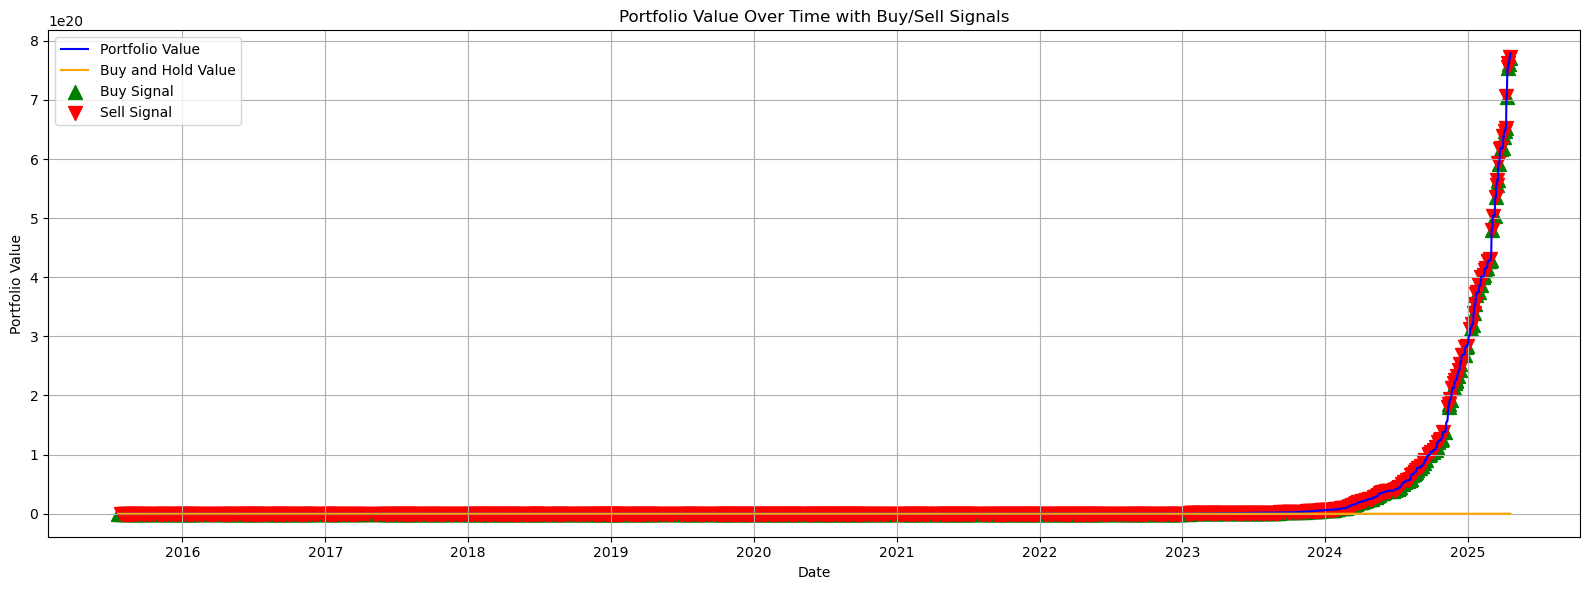

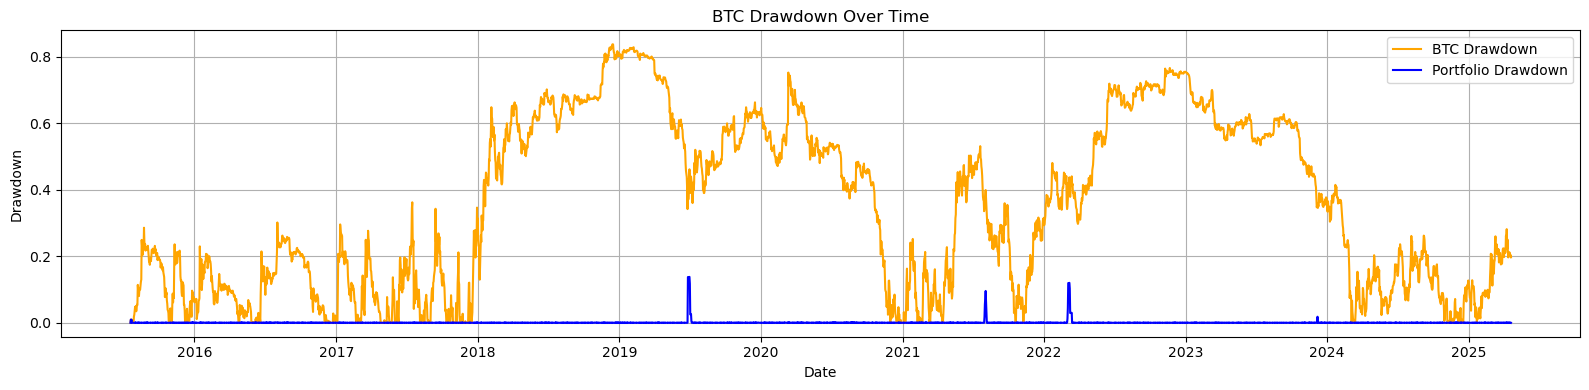

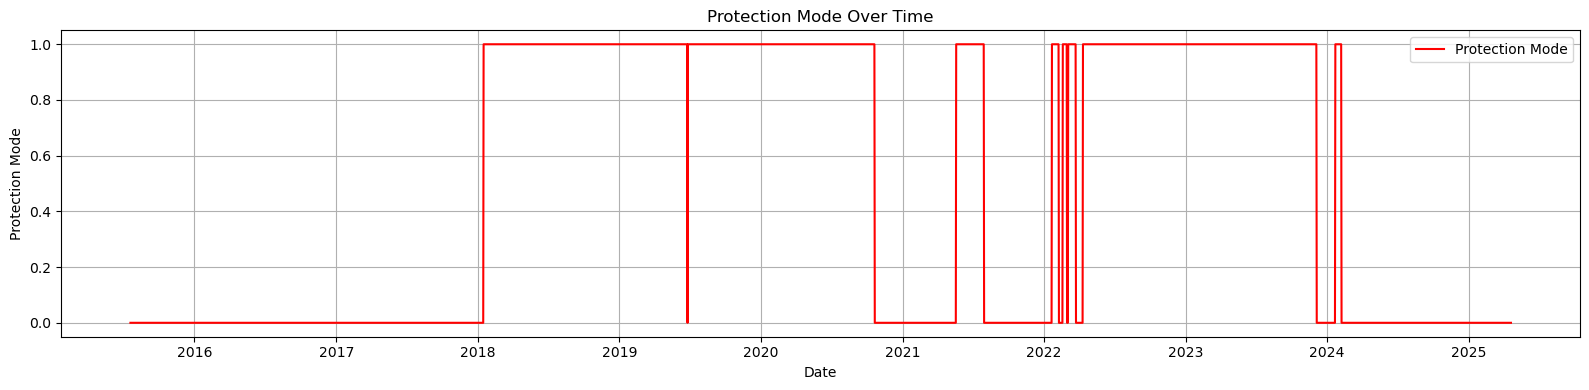

In [119]:
simmulation = simmulate(signals_df, initial_cash=100, long_position=1, short_position=0, transaction_fee=0.001, max_drawdown_threshold=0.4, drawdown_buffer=0.05)

plot_portfolio_with_signals(simmulation)
plot_drawdown(simmulation)
plot_protection_mode(simmulation)


# Feature Engineering

In [120]:
df['Signal'] = signals

# add all the features
df_features = add_all_features(df)
df_features.head(3)

,Open,High,Low,Close,Volume,Risk Free Rate,Signal,Returns,Excess_Return,MA_Close_3,...,STOCHk_14_3_3,STOCHd_14_3_3,ADX_14,DMP_14,DMN_14,Signal_Lag_1,Signal_Lag_2,Signal_Lag_3,Signal_Lag_4,Signal_Lag_5
2015-08-22,232.85,235.53,222.68,231.15,7197.349489,0.000056,0.0,-0.007301,-0.007357,233.186667,...,42.604897,38.677777,56.450690,3.482493,45.598450,0.0,-1.0,0.0,1.0,0.0
2015-08-23,231.16,233.25,226.15,229.21,4312.637690,0.000056,0.0,-0.008393,-0.008449,231.070000,...,41.450235,41.116721,59.108266,3.309747,43.336578,0.0,0.0,-1.0,0.0,1.0
2015-08-24,229.23,229.24,210.00,211.16,16523.789445,0.000054,1.0,-0.078749,-0.078803,223.840000,...,32.928177,38.994436,61.740489,2.891214,48.471033,0.0,0.0,0.0,-1.0,0.0


## Checkking for stationarity

In [121]:
# test which features are stationery
from statsmodels.tsa.stattools import adfuller


non_stationary = []
for col in df_features.columns:
    result = adfuller(df_features[col])
    if result[1] > 0.05:
        print(f"{col}: not stationary")
        non_stationary.append(col)

Open: not stationary
High: not stationary
Low: not stationary
Close: not stationary
Risk Free Rate: not stationary
MA_Close_3: not stationary
MA_Close_5: not stationary
MA_Close_10: not stationary
MA_Close_30: not stationary
EMA_Close_3: not stationary
EMA_Close_5: not stationary
EMA_Close_10: not stationary
EMA_Close_30: not stationary
BBL_5_2.0: not stationary
BBU_5_2.0: not stationary
BBL_10_2.0: not stationary
BBU_10_2.0: not stationary
BBL_20_2.0: not stationary
BBU_20_2.0: not stationary
ATRr_5: not stationary
ATRr_10: not stationary
ATRr_20: not stationary


In [122]:
# check what becomes stationery if we difference by 1
diffed_stationary = []
for col in non_stationary:
    diffed = df_features[col].diff().dropna()
    diffed_result = adfuller(diffed)
    if diffed_result[1] > 0.05:
        print(f"{col}: differencing by 1 is not enough")
        diffed_stationary.append(col)
    

If we difference by 1 for the non stationary features, everything becomes stationery
- Whatever needs to be made stationery is in diffed_stationary


In [123]:
df_features[diffed_stationary] = df_features[diffed_stationary].diff().dropna()
df_features.head(3)

,Open,High,Low,Close,Volume,Risk Free Rate,Signal,Returns,Excess_Return,MA_Close_3,...,STOCHk_14_3_3,STOCHd_14_3_3,ADX_14,DMP_14,DMN_14,Signal_Lag_1,Signal_Lag_2,Signal_Lag_3,Signal_Lag_4,Signal_Lag_5
2015-08-22,232.85,235.53,222.68,231.15,7197.349489,0.000056,0.0,-0.007301,-0.007357,233.186667,...,42.604897,38.677777,56.450690,3.482493,45.598450,0.0,-1.0,0.0,1.0,0.0
2015-08-23,231.16,233.25,226.15,229.21,4312.637690,0.000056,0.0,-0.008393,-0.008449,231.070000,...,41.450235,41.116721,59.108266,3.309747,43.336578,0.0,0.0,-1.0,0.0,1.0
2015-08-24,229.23,229.24,210.00,211.16,16523.789445,0.000054,1.0,-0.078749,-0.078803,223.840000,...,32.928177,38.994436,61.740489,2.891214,48.471033,0.0,0.0,0.0,-1.0,0.0


## Feature Scaling and Selection

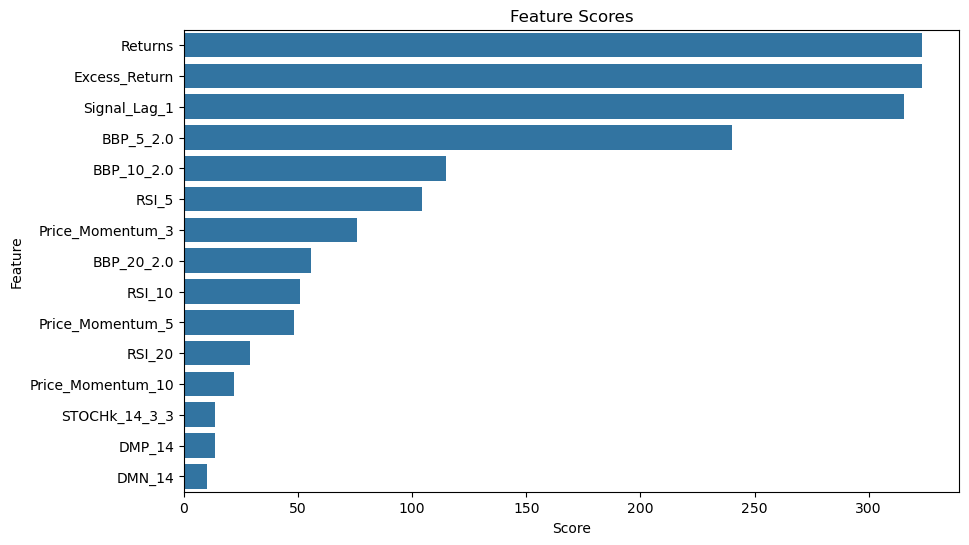

In [124]:
X_train, y_train, X_test, y_test = split_data(df_features, 
                                              date_split = '2021-01-01', 
                                              start_date = 
                                              df.index[0], 
                                              end_date = df.index[-1])

X_train, y_train, X_test, y_test = select_top(X_train, y_train, X_test, y_test, k=15, plot=True)



In [125]:
# plot X_train and test
px.line(X_train, title='X_train').show()
px.line(X_test, title='X_test').show()

# Model Building

## Random Forest

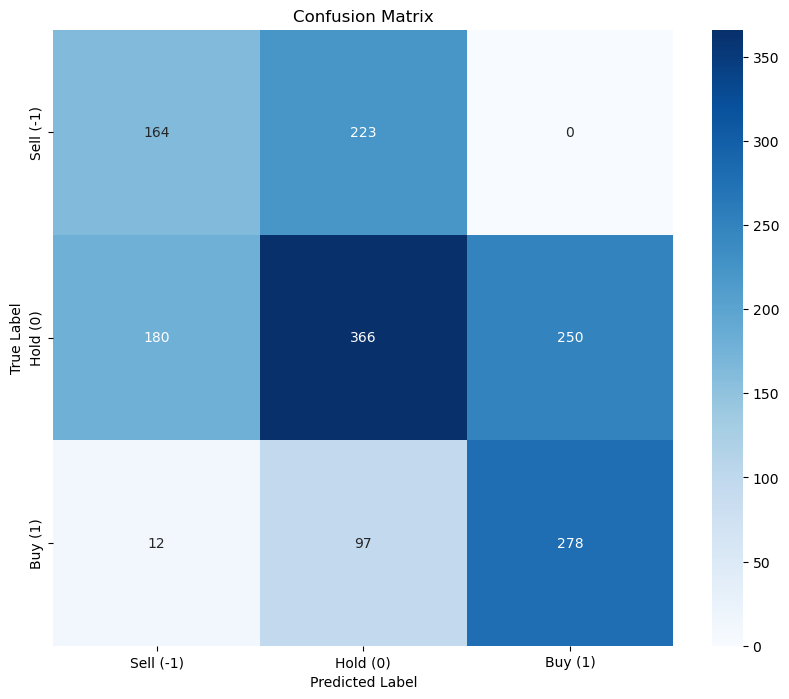

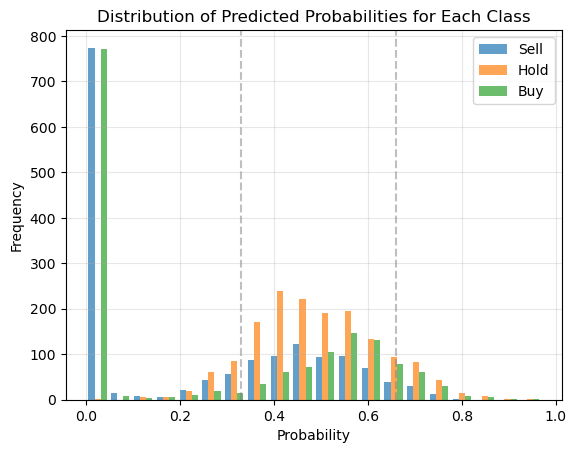

              precision    recall  f1-score   support

          -1       0.46      0.42      0.44       387
           0       0.53      0.46      0.49       796
           1       0.53      0.72      0.61       387

    accuracy                           0.51      1570
   macro avg       0.51      0.53      0.51      1570
weighted avg       0.51      0.51      0.51      1570



In [126]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)


# rf.fit(X_train, vector_to_signal(y_train)) # multi class classifier

rf.fit(X_train, y_train) # to have a seperate classifiers for each class

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)


report(y_test, y_pred, y_proba)

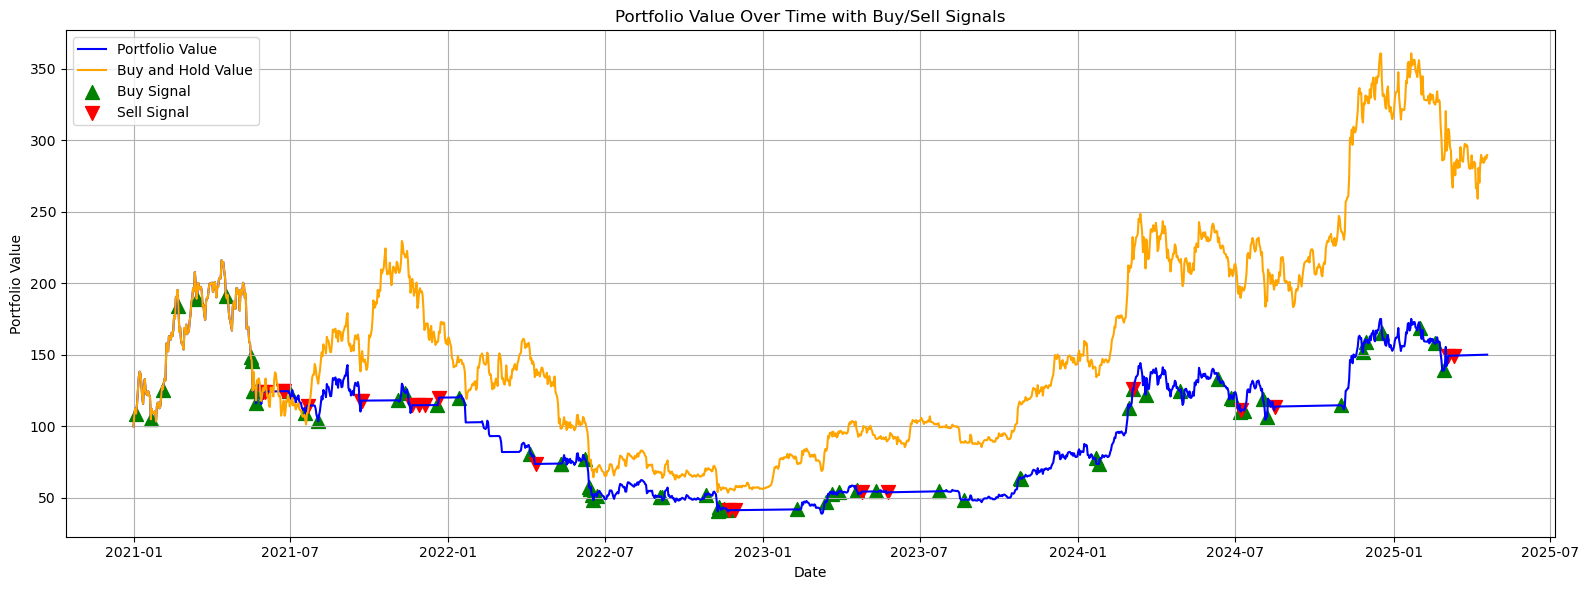

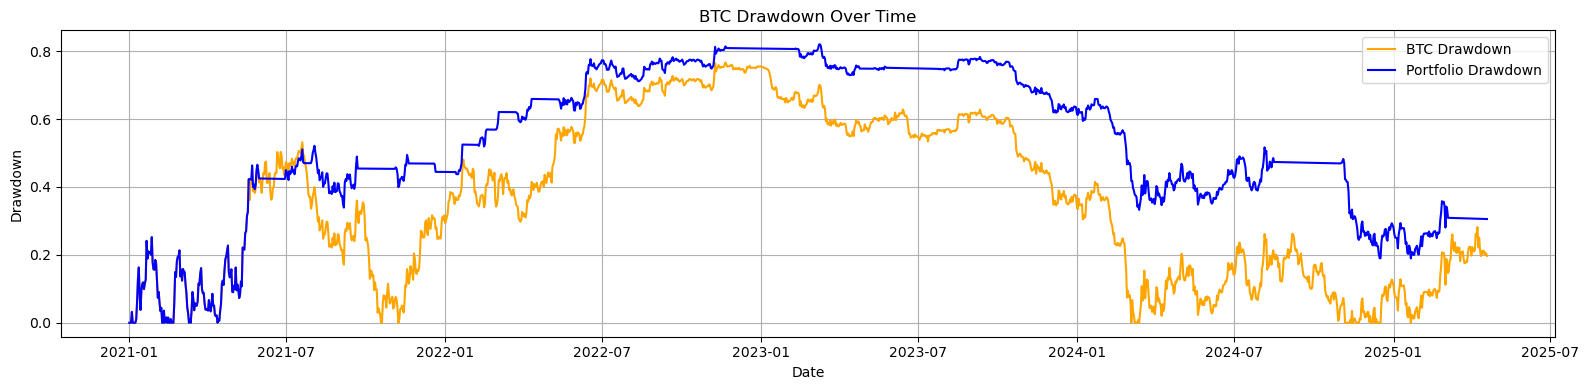

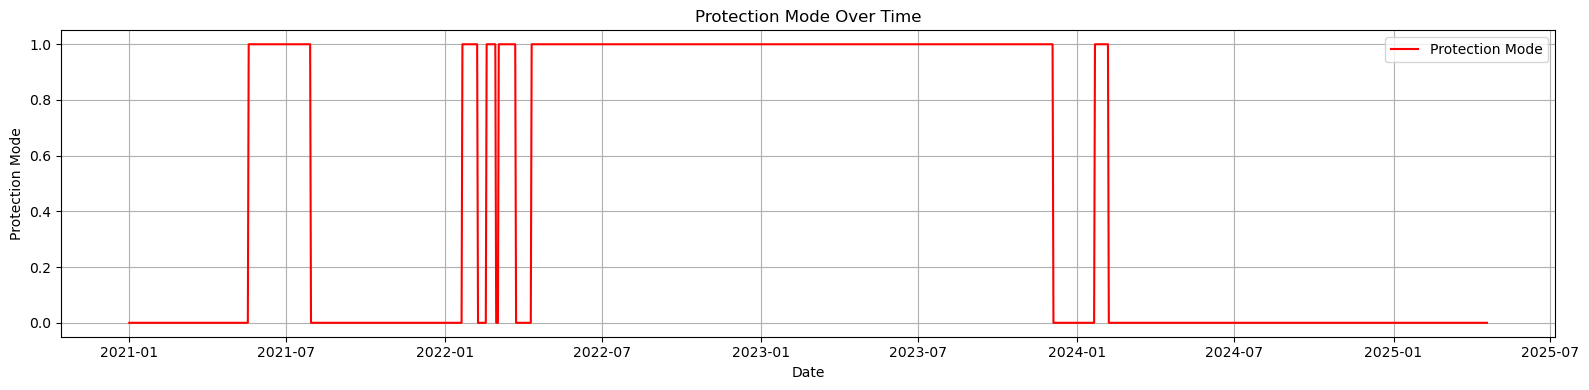

REPORT
--------------------------------
Date Range: 2021-01-01 00:00:00 - 2025-04-19 00:00:00
--------------------------------
Strategy Total Return: 150.15%
Buy and Hold Total Return: 289.80%
Strategy Improvement (%) : -48.19%
--------------------------------
Strategy Sharpe Ratio: 0.02
Buy and Hold Sharpe Ratio: 0.03
Strategy Improvement (%) : -42.10%
--------------------------------
Strategy Max Drawdown: 82.01%
Buy and Hold Max Drawdown: 76.67%
Strategy Improvement (%) : 6.96%
--------------------------------
# Buy Signals: 66
# Sell Signals: 21
# Hold Signals: 1483
--------------------------------


In [127]:
signals_df = simulate_df(y_proba, df, X_test, threshold=0.7)
signals_df.head(3)

simmulation = simmulate(signals_df, initial_cash=100, long_position=1, short_position=0, transaction_fee=0.001, max_drawdown_threshold=0.4, drawdown_buffer=0.05)

plot_portfolio_with_signals(simmulation)
plot_drawdown(simmulation)
plot_protection_mode(simmulation)

generate_report(simmulation, verbose=True)


## XGBoost

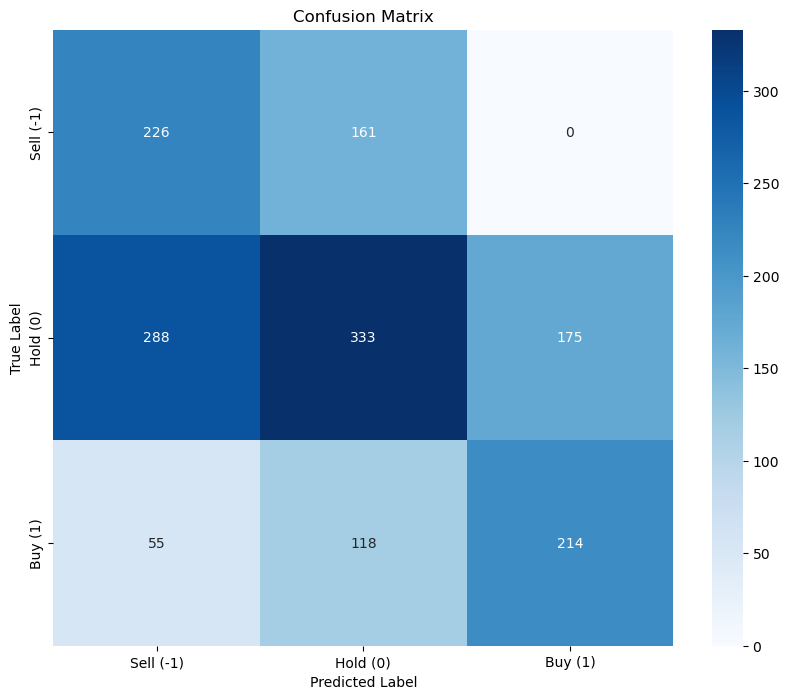

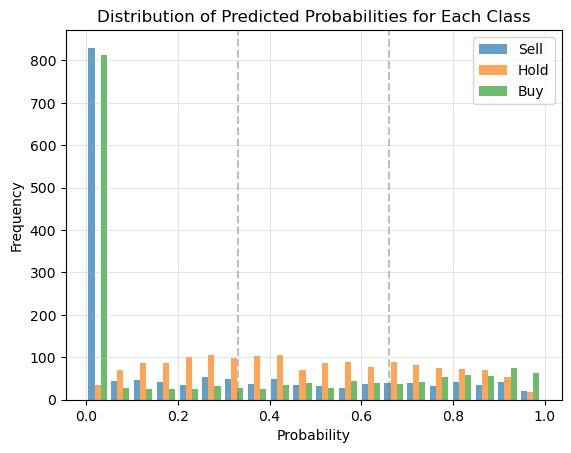

              precision    recall  f1-score   support

          -1       0.40      0.58      0.47       387
           0       0.54      0.42      0.47       796
           1       0.55      0.55      0.55       387

    accuracy                           0.49      1570
   macro avg       0.50      0.52      0.50      1570
weighted avg       0.51      0.49      0.49      1570



In [128]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)


report(y_test, vector_to_signal(y_pred), y_proba)

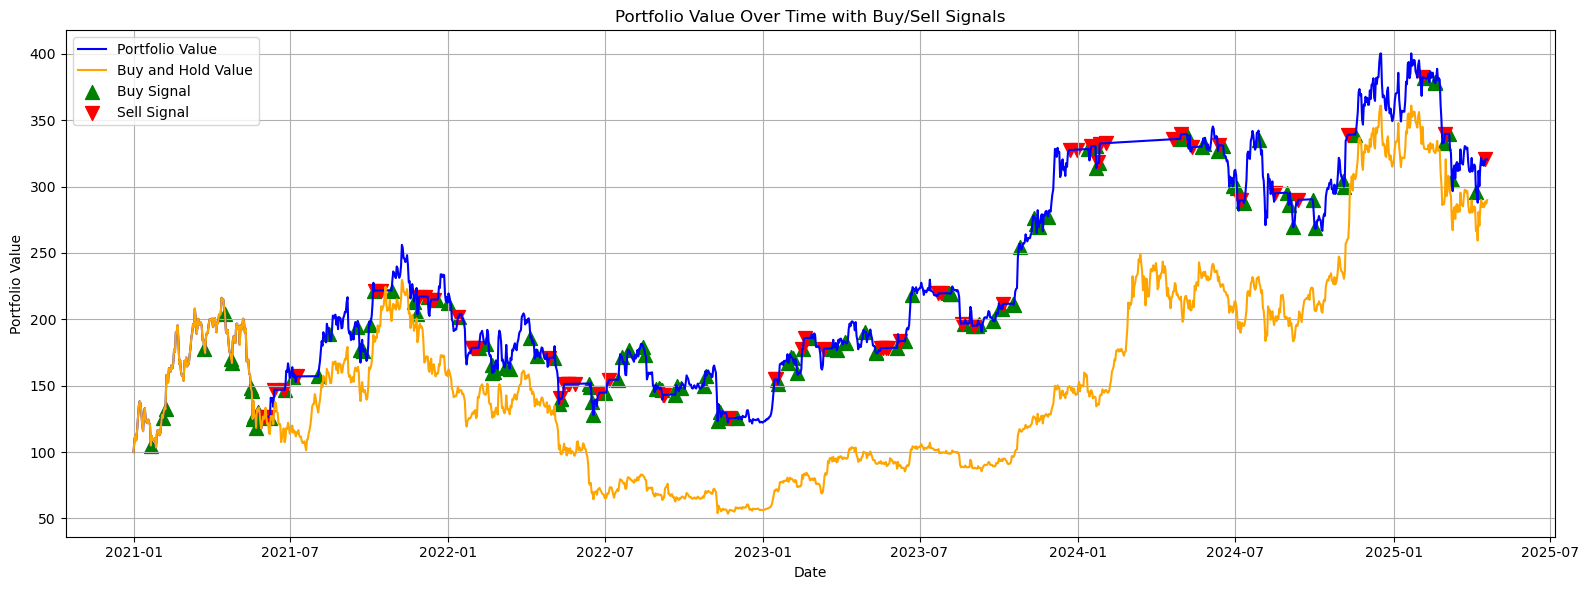

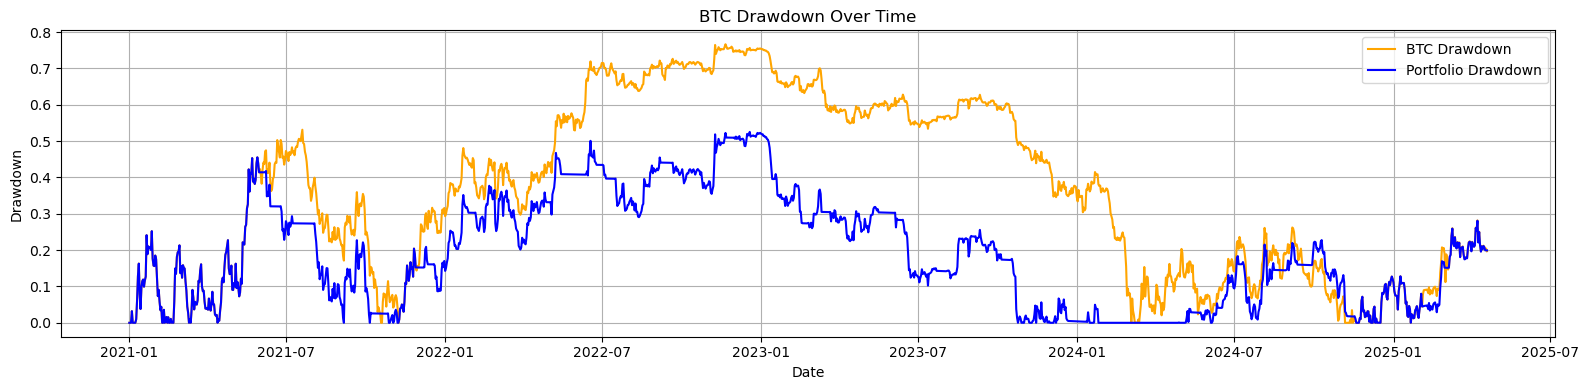

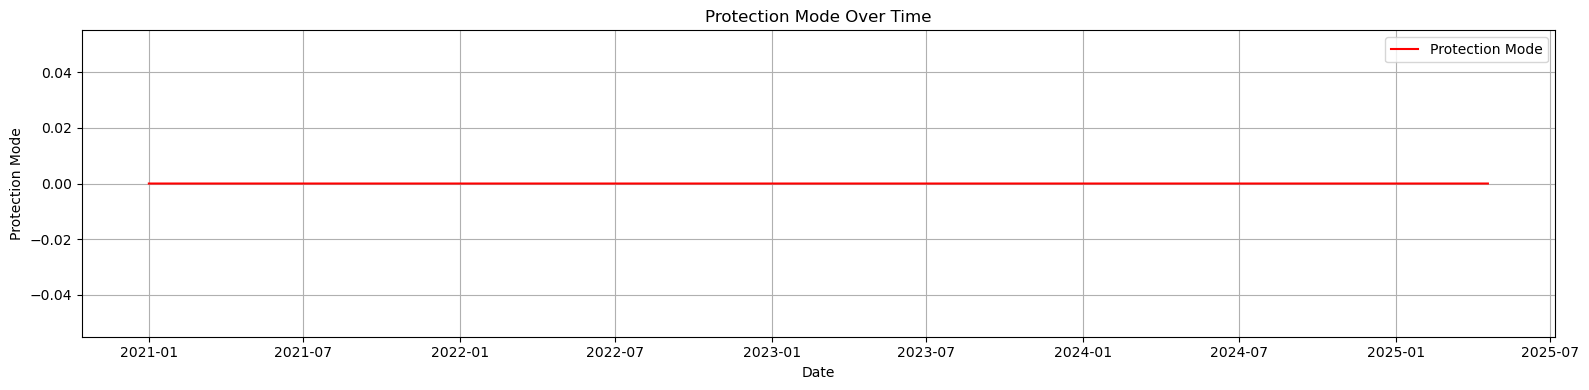

REPORT
--------------------------------
Date Range: 2021-01-01 00:00:00 - 2025-04-19 00:00:00
--------------------------------
Strategy Total Return: 320.47%
Buy and Hold Total Return: 289.80%
Strategy Improvement (%) : 10.59%
--------------------------------
Strategy Sharpe Ratio: 0.04
Buy and Hold Sharpe Ratio: 0.03
Strategy Improvement (%) : 9.21%
--------------------------------
Strategy Max Drawdown: 52.55%
Buy and Hold Max Drawdown: 76.67%
Strategy Improvement (%) : -31.46%
--------------------------------
# Buy Signals: 133
# Sell Signals: 59
# Hold Signals: 1378
--------------------------------


In [129]:
signals_df = simulate_df(y_proba, df, X_test, threshold=0.90)
signals_df.head(3)

simmulation = simmulate(signals_df, initial_cash=100, long_position=1, short_position=0, transaction_fee=0.001, max_drawdown_threshold=1, drawdown_buffer=0.05)

plot_portfolio_with_signals(simmulation)
plot_drawdown(simmulation)
plot_protection_mode(simmulation)

generate_report(simmulation, verbose=True)


## Neural Network

In [134]:
import torch
from torch import nn
from torch.utils.data import DataLoader

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

display(X_train.head(3))
display(y_train.head(3))


Using mps device


,Returns,Excess_Return,Price_Momentum_3,Price_Momentum_5,Price_Momentum_10,BBP_5_2.0,BBP_10_2.0,BBP_20_2.0,RSI_5,RSI_10,RSI_20,STOCHk_14_3_3,DMP_14,DMN_14,Signal_Lag_1
2015-08-22,-0.267660,-0.267674,0.104735,-1.334602,-1.273721,0.071752,-0.924315,-1.387721,-1.275947,-1.672325,-2.005146,-0.650407,-2.038831,2.676441,-0.000729
2015-08-23,-0.295341,-0.295355,-0.543126,0.185469,-1.272979,-0.806953,-0.871475,-1.335828,-1.373347,-1.734161,-2.059127,-0.694860,-2.056673,2.429527,-0.000729
2015-08-24,-2.078805,-2.078759,-1.524091,-0.989150,-1.829506,-1.895620,-1.474289,-1.773749,-1.951721,-2.185514,-2.482714,-1.022952,-2.099899,2.990021,-0.000729


,Signal_Sell,Signal_Hold,Signal_Buy
2015-08-22,0.0,1.0,0.0
2015-08-23,0.0,1.0,0.0
2015-08-24,0.0,0.0,1.0


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
